In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


In [2]:
!pip install transformers
!pip install sentencepiece

In [3]:
TRAIN_DATA_PATH = '/kaggle/input/tweet-sentiment-extraction/train.csv'
TEST_DATA_PATH = '/kaggle/input/tweet-sentiment-extraction/test.csv'
output_dir = '/kaggle/working/'
BATCH_SIZE = 16
EPOCHS = 4
MAX_LEN = 150
TRAIN_SIZE = 0.95
VAL_SIZE = 0.1
SEED_VAL = 42

In [4]:
import pandas as pd
import numpy as np
import os
import time
import datetime
import random

# Visualisation libraries
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


#Transformers
from transformers import AlbertTokenizer
from transformers import AlbertForSequenceClassification, AdamW, AlbertConfig
from transformers import get_linear_schedule_with_warmup

In [5]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
test_df = pd.read_csv(TEST_DATA_PATH)
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
#Missing values in training set
train_df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [9]:
# Dropping missing values
train_df.dropna(axis = 0, how ='any',inplace=True)

In [10]:
train_df.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [11]:
# Distribution of the Sentiment Column
train_df['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [12]:
train_df['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [13]:
l1 = train_df.sentiment.unique()
len(l1)

3

In [14]:
possible_labels = train_df.sentiment.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

train_df['label'] = train_df.sentiment.replace(label_dict)
print(label_dict)
train_df.head()

{'neutral': 0, 'negative': 1, 'positive': 2}


,textID,text,selected_text,sentiment,label
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1
2,088c60f138,my boss is bullying me...,bullying me,negative,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,1


In [15]:
# Positive tweet
print("Positive Tweet example :",train_df[train_df['sentiment']=='positive']['text'].values[0])
#negative_text
print("Negative Tweet example :",train_df[train_df['sentiment']=='negative']['text'].values[0])
#neutral_text
print("Neutral tweet example  :",train_df[train_df['sentiment']=='neutral']['text'].values[0])

Positive Tweet example : 2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet example :  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example  :  I`d have responded, if I were going


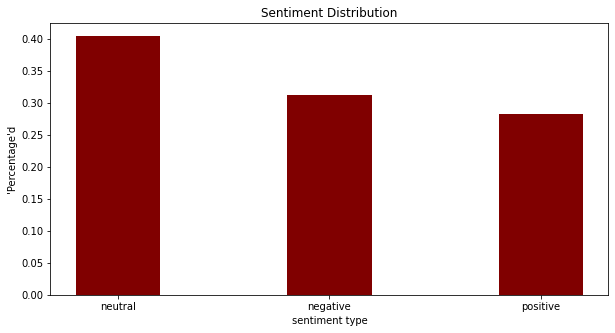

In [16]:
# creating the bar plot
fig = plt.figure(figsize = (10, 5))
plt.bar(l1,train_df['sentiment'].value_counts(normalize=True), color ='maroon',
        width = 0.4)
 
plt.xlabel("sentiment type")
plt.ylabel("'Percentage'd")
plt.title("Sentiment Distribution")
plt.show()

## Tokenization
Tokenizing the sentences using Bert Tokenizer from Hugging Face 🤗

In [17]:
# Load the ALBERT tokenizer.
print('Loading ALBERT tokenizer...')
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

Loading ALBERT tokenizer...


Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [18]:
# Tokenizing the first text
print(train_df['text'][10]) # original sentence
print(tokenizer.tokenize(train_df['text'][10]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df['text'][10])))

 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
['▁as', '▁much', '▁as', '▁i', '▁love', '▁to', '▁be', '▁hopeful', ',', '▁i', '▁reckon', '▁the', '▁chances', '▁are', '▁minimal', '▁=', 'p', '▁i', '`', 'm', '▁never', '▁gonna', '▁get', '▁my', '▁cake', '▁and', '▁stuff']
[28, 212, 28, 31, 339, 20, 44, 19562, 15, 31, 17453, 14, 11285, 50, 8663, 800, 306, 31, 1, 79, 243, 5172, 164, 51, 8390, 17, 3217]


## Preprocessing data for AlBert
AlBERT expects input data in a specific format i.e

- Tokenized dataset
- All the vectors should be of the same size.Hence,we need to pad the text to achieve a common length.This length will be decided by the length of longest sentence, which we will have to calculate.Also, since we shall concatanate the text and the sentiment column, the length should be decided by the concatanated text column.
- We need to then differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".

From the Hugging face documentation The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicate a value that should be attended to while 0 indicate a padded value.

Adding special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]).

In [19]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)

[SEP] 3
[CLS] 2


In [20]:
max_len = 0

# For every sentence...
for sent in train_df['text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  126


We shall take the maximum length to be 150 since we shall be concatenating text and sentiment columns. There is a very helpful function called encode_plus provided in the Tokenizer class which can prove to be real handly. It can seamlessly perform the following operations:

- Tokenize the text
- Add special tokens - [CLS] and [SEP]
- create token IDs
- Pad the sentences to a common length
- Create attention masks for the above PAD tokens

In [21]:
text = train_df['text'].values
sentiment = train_df['sentiment'].values
labels = train_df.label.values

What we get are 2 tensors. Let me briefly go over them:

- 1) input_ids : list of token ids to be fed to a model. We can see that all token ids have been padded to a length of 150.
- 2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

In [22]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
token_type_ids = []

# For every sentence...
 # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

for sent in text:
  encoded_dict= tokenizer.encode_plus(
      sent, # Sentence to encode.
      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
      max_length = MAX_LEN, # Pad & truncate all sentences. Just in case there are some longer tes
      pad_to_max_length = True,
      return_attention_mask = True,  # Construct attn. masks
      return_tensors = 'pt', # Return pytorch tensors.
      truncation=True
  )
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', text[0])
print('Token IDs:', input_ids[0])
print('label :', labels[0])



/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   I`d have responded, if I were going
Token IDs: tensor([   2,   31,    1,   43,   57, 4567,   15,  100,   31,   46,  228,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,

In [23]:

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(TRAIN_SIZE * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

26,106 training samples
1,374 validation samples


In [24]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )
        

In [25]:
# Load AlertForSequenceClassification, the pretrained ALBERT model with a single 
# linear classification layer on top.

model = AlbertForSequenceClassification.from_pretrained(
    "albert-large-v2", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels =3 , # The number of output labels--2 for binary classification.# You can increase this for multi-class tasks
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    return_dict = False,
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/685 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-large-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You s

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=1024, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_featur

In [26]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The ALBERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The ALBERT model has 27 different named parameters.

==== Embedding Layer ====

albert.embeddings.word_embeddings.weight                (30000, 128)
albert.embeddings.position_embeddings.weight              (512, 128)
albert.embeddings.token_type_embeddings.weight              (2, 128)
albert.embeddings.LayerNorm.weight                            (128,)
albert.embeddings.LayerNorm.bias                              (128,)

==== First Transformer ====

albert.encoder.embedding_hidden_mapping_in.weight        (1024, 128)
albert.encoder.embedding_hidden_mapping_in.bias              (1024,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight      (1024,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias      (1024,)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight (1024, 1024)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias      (1024,)
albert.encoder.albert_layer_groups.0.albert

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [28]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS


# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
torch.cuda.empty_cache()

In [32]:
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, EPOCHS):
  # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 150 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch   150  of  1,632.    Elapsed: 0:02:01.
  Batch   300  of  1,632.    Elapsed: 0:04:01.
  Batch   450  of  1,632.    Elapsed: 0:06:00.
  Batch   600  of  1,632.    Elapsed: 0:08:00.
  Batch   750  of  1,632.    Elapsed: 0:10:00.
  Batch   900  of  1,632.    Elapsed: 0:12:00.
  Batch 1,050  of  1,632.    Elapsed: 0:14:00.
  Batch 1,200  of  1,632.    Elapsed: 0:16:00.
  Batch 1,350  of  1,632.    Elapsed: 0:17:59.
  Batch 1,500  of  1,632.    Elapsed: 0:19:59.

  Average training loss: 0.65
  Training epcoh took: 0:21:44

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.53
  Validation took: 0:00:24

======== Epoch 2 / 4 ========
Training...
  Batch   150  of  1,632.    Elapsed: 0:02:00.
  Batch   300  of  1,632.    Elapsed: 0:04:00.
  Batch   450  of  1,632.    Elapsed: 0:06:00.
  Batch   600  of  1,632.    Elapsed: 0:08:00.
  Batch   750  of  1,632.    Elapsed: 0:09:59.
  Batch   900  of  1,632.    Elapsed: 0:11:59.
  Batch 1

In [33]:
# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/spiece.model',
 '/kaggle/working/added_tokens.json')

In [34]:
!pwd

/kaggle/working


In [35]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.65,0.53,0.79,0:21:44,0:00:24
2,0.50,0.48,0.81,0:21:44,0:00:24
3,0.40,0.51,0.81,0:21:46,0:00:24
4,0.29,0.58,0.81,0:21:47,0:00:24


## Prediction

In [36]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [37]:
test_df.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [42]:
possible_labels = test_df.sentiment.unique()
print(possible_labels)

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = int(index)

test_df['label'] = test_df.sentiment.replace(label_dict)
print(label_dict)
test_df.head()

['neutral' 'positive' 'negative']
{'neutral': 0, 'positive': 1, 'negative': 2}


,textID,text,sentiment,label
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,1
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,2
3,01082688c6,happy bday!,positive,1
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,1


In [44]:
# Create sentence and label lists
sentences = test_df.text.values
labels = test_df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [45]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,534 test sentences...
    DONE.


In [46]:
true_labels[0]

array([0, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2])

In [47]:
predictions[0]

array([[ 3.9308424 , -2.1118946 , -1.894315  ],
       [-2.0289876 , -2.8358643 ,  3.8152099 ],
       [-1.4529651 ,  3.3934033 , -2.3779206 ],
       [-2.3170335 , -2.46431   ,  3.6081624 ],
       [-1.7420188 , -2.7233586 ,  3.7330453 ],
       [-2.441774  , -2.5223796 ,  3.8299391 ],
       [-1.3449844 ,  3.3108537 , -2.600388  ],
       [ 0.00786206,  1.3505671 , -2.100869  ],
       [ 3.6514804 , -1.3910015 , -2.3107696 ],
       [ 2.6938252 , -2.1707664 , -0.901226  ],
       [-1.1328133 ,  2.7890773 , -2.362101  ],
       [ 1.8612751 ,  0.6276171 , -2.0853093 ],
       [ 3.2637825 , -1.9999546 , -1.8218031 ],
       [-1.4982626 ,  3.40252   , -2.2979531 ],
       [ 0.89715827,  1.6081741 , -2.5889883 ],
       [-1.6064347 ,  3.4972548 , -2.2702813 ]], dtype=float32)